In [106]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage

## Read the data

In [107]:
data = pd.read_csv('spotify-2023.csv', encoding='latin-1')
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

## 858 lignes pour key et 903 lignes pour in_shazam_charts

In [109]:
df_key = data[data['in_shazam_charts'].notnull()]
df = df_key[df_key['key'].notnull()]
df.loc[:, 'mode'] = [0 if x == 'Minor' else 1 for x in df['mode']]

key_mapping = {
    'A#': 'A',
    'C#': 'C',
    'D#': 'D',
    'F#': 'F',
    'G#': 'G'
}
df.loc[:, 'key_merged'] = df['key'].replace(key_mapping)

/var/folders/wz/q1btcv1x65l01tq61b7l7_rr0000gn/T/ipykernel_9035/1657754457.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'key_merged'] = df['key'].replace(key_mapping)


<Axes: xlabel='key', ylabel='count'>

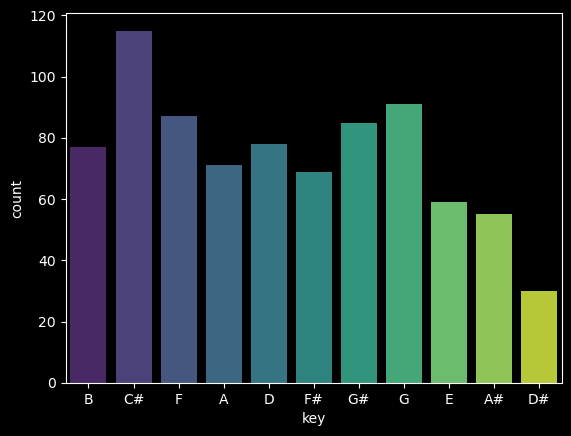

In [110]:
sns.countplot(x='key', data=df, palette='viridis')
#Nombre de musiques totales par clés

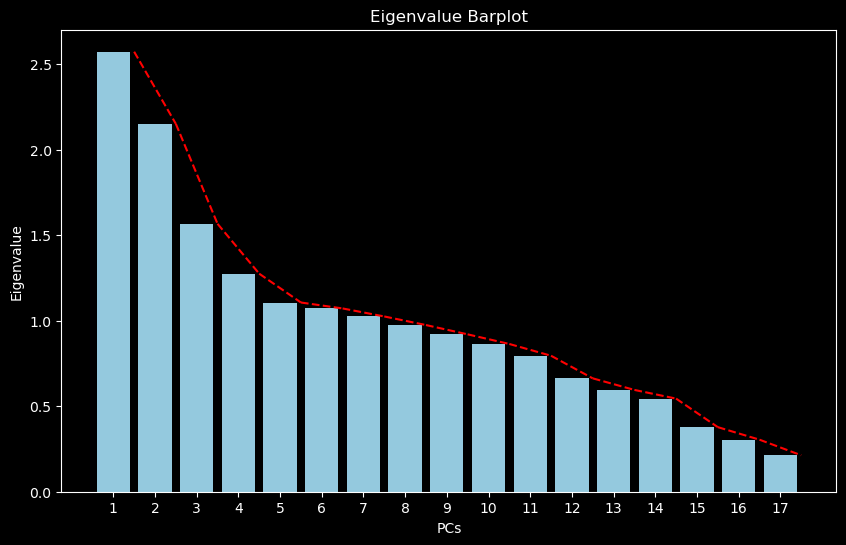

In [111]:
numerical_df = df.select_dtypes(include=np.number)

# Standardize the data (Z = (X - mean)/sd)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Get the eigenvalues
eigenvalues = pca.explained_variance_

# Plot the eigenvalues
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(eigenvalues) + 1), y=eigenvalues, color='skyblue')
plt.xlabel('PCs')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Barplot')
for i in range(len(eigenvalues) - 1):
    plt.plot([i + 0.5, i + 1.5], [eigenvalues[i], eigenvalues[i + 1]], color='red', linestyle='--')
plt.show()

/var/folders/wz/q1btcv1x65l01tq61b7l7_rr0000gn/T/ipykernel_9035/389831900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bpm_class'] = pd.cut(df['bpm'], bins=[interval[0] for interval in class_intervals] + [float('inf')], labels=class_labels)


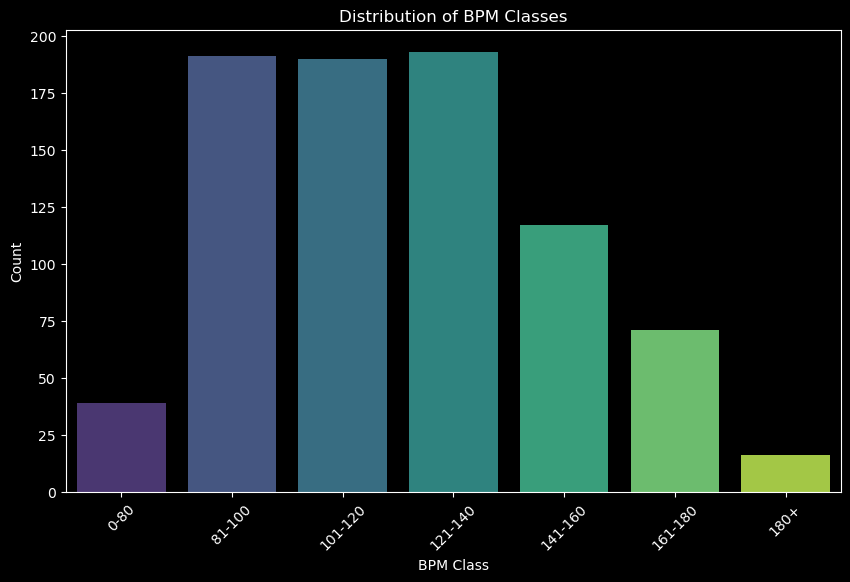

In [112]:
class_intervals = [(0, 80), (81, 100), (101, 120), (121, 140), (141, 160), (161, 180), (181, float('inf'))]
class_labels = ['0-80', '81-100', '101-120', '121-140', '141-160', '161-180', '180+']

# Assign each bpm value to a class
df['bpm_class'] = pd.cut(df['bpm'], bins=[interval[0] for interval in class_intervals] + [float('inf')], labels=class_labels)

# Create the barplot
plt.figure(figsize=(10, 6))
sns.countplot(x='bpm_class', data=df, palette='viridis')
plt.xlabel('BPM Class')
plt.ylabel('Count')
plt.title('Distribution of BPM Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#121-140 max count

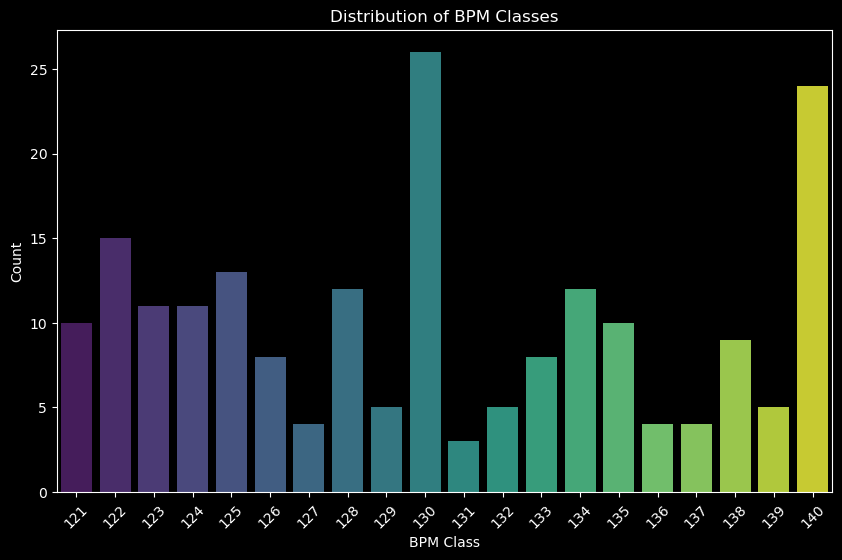

In [113]:
bpm_121_140_df = df[(df['bpm'] >= 121) & (df['bpm'] <= 140)]

# Create the barplot
plt.figure(figsize=(10, 6))
sns.countplot(x='bpm', data=bpm_121_140_df, palette='viridis')
plt.xlabel('BPM Class')
plt.ylabel('Count')
plt.title('Distribution of BPM Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#130 bpm is the most counted, next is 140

## PCA sur la bpm_class ne donne rien

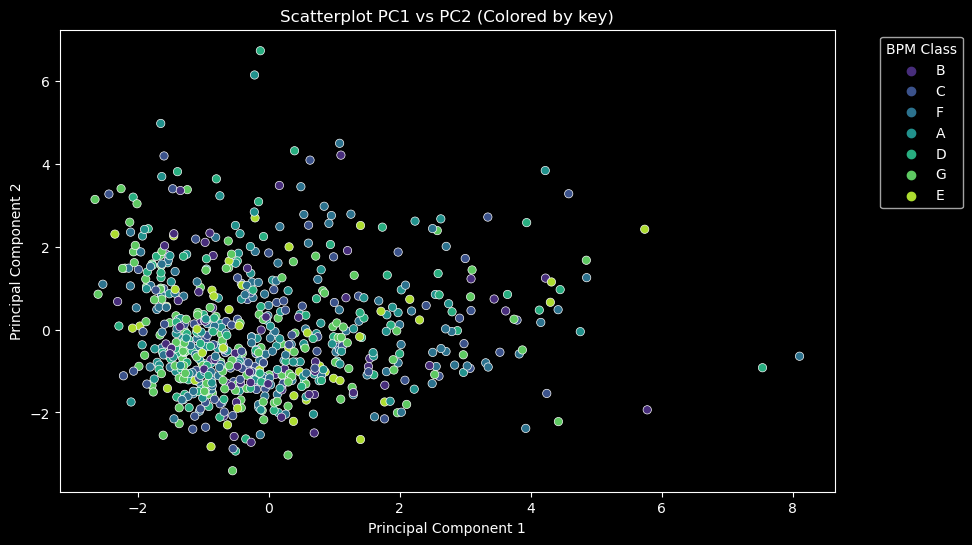

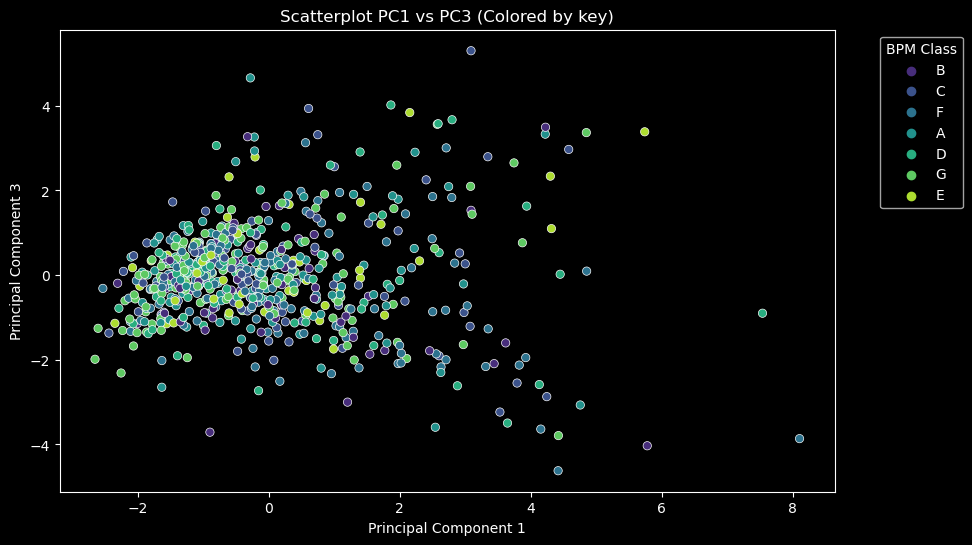

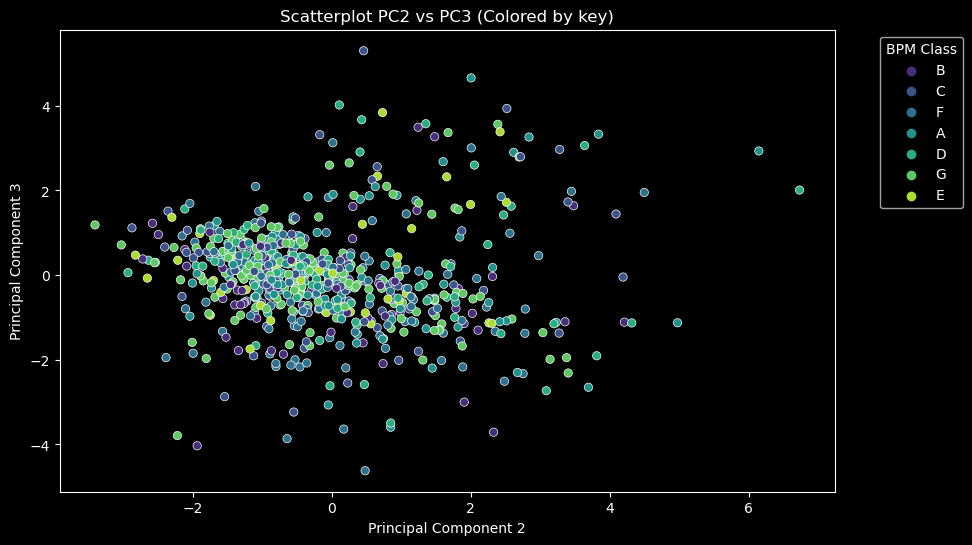

In [123]:
pca_data = pca.transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['bpm_class'] = df['bpm_class']
pca_df['mode'] = df['mode']
pca_df['key'] = df['key_merged']

# Plot the scatterplot of the first two principal components colored by 'bpm_class'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='key', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot PC1 vs PC2 (Colored by key)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='key', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC1 vs PC3 (Colored by key)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='key', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC2 vs PC3 (Colored by key)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

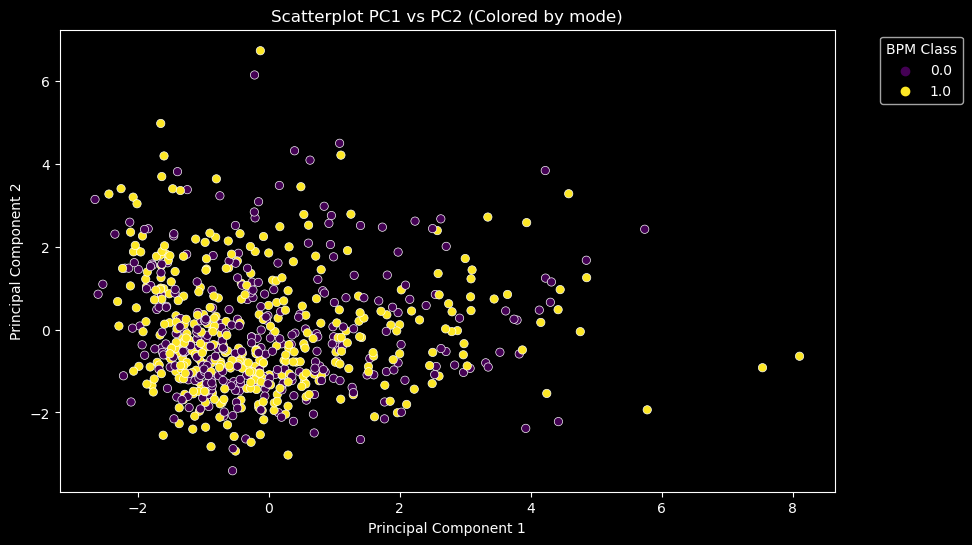

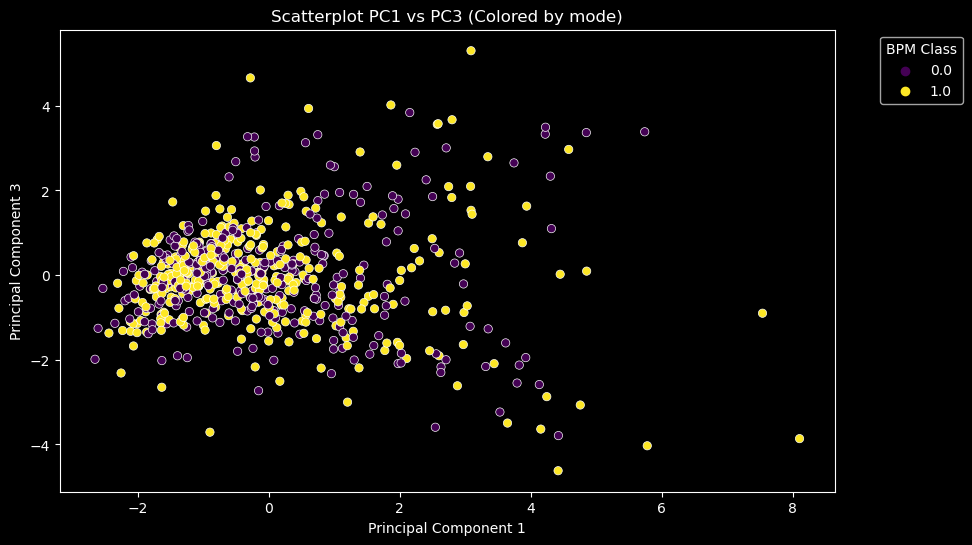

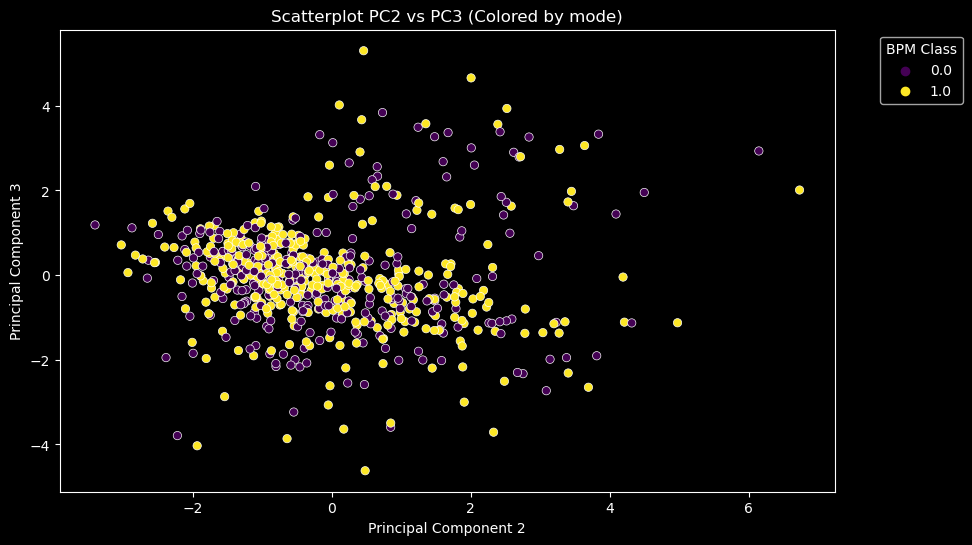

In [124]:
# Plot the scatterplot of the first two principal components colored by 'bpm_class'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='mode', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot PC1 vs PC2 (Colored by mode)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='mode', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC1 vs PC3 (Colored by mode)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='mode', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC2 vs PC3 (Colored by mode)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [125]:
mds = MDS(n_components=3)
mds_data = mds.fit_transform(scaled_data)

# Convert MDS result to DataFrame
mds_df = pd.DataFrame(data=mds_data, columns=['MDS1', 'MDS2', 'MDS3'])
mds_df['bpm_class'] = df['bpm_class']
mds_df['mode'] = df['mode']
mds_df['key'] = df['key_merged']

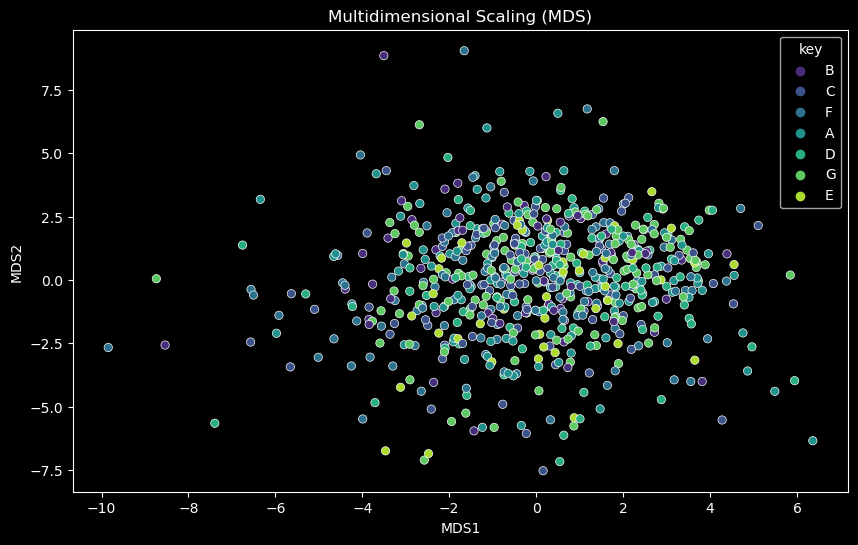

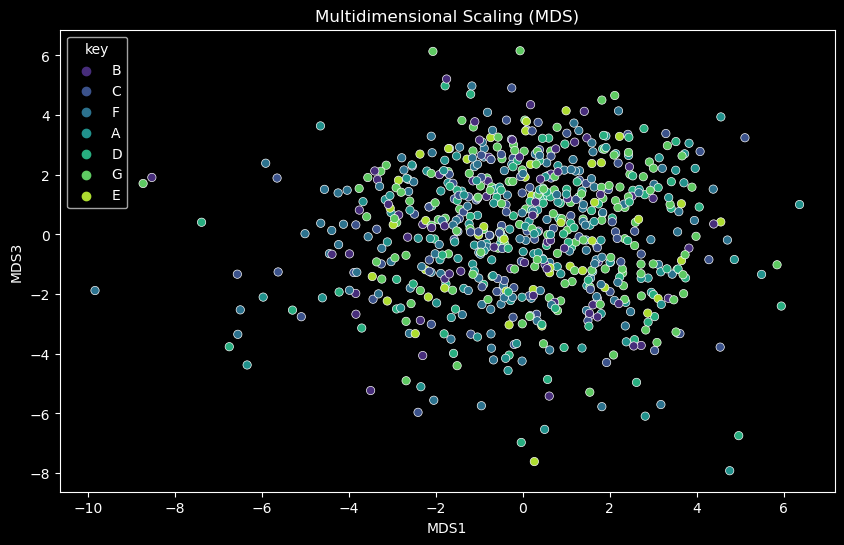

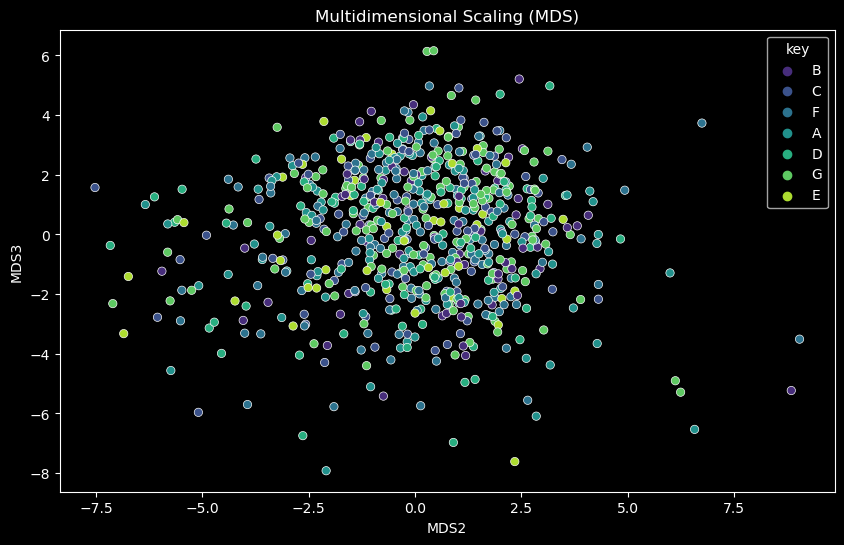

In [127]:
# Plot the scatterplot of the MDS result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS2', hue = 'key', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS3', hue = 'key', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS2', y='MDS3', hue = 'key', data=mds_df, palette='viridis')
plt.xlabel('MDS2')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

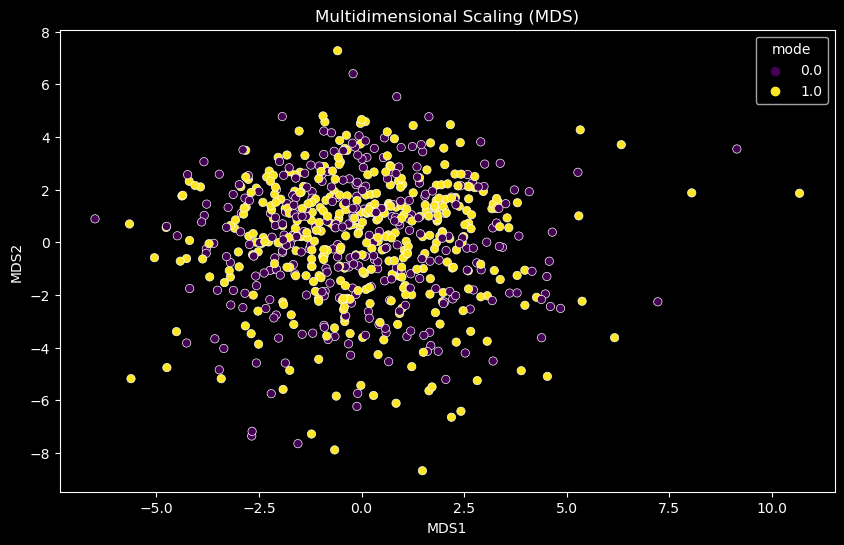

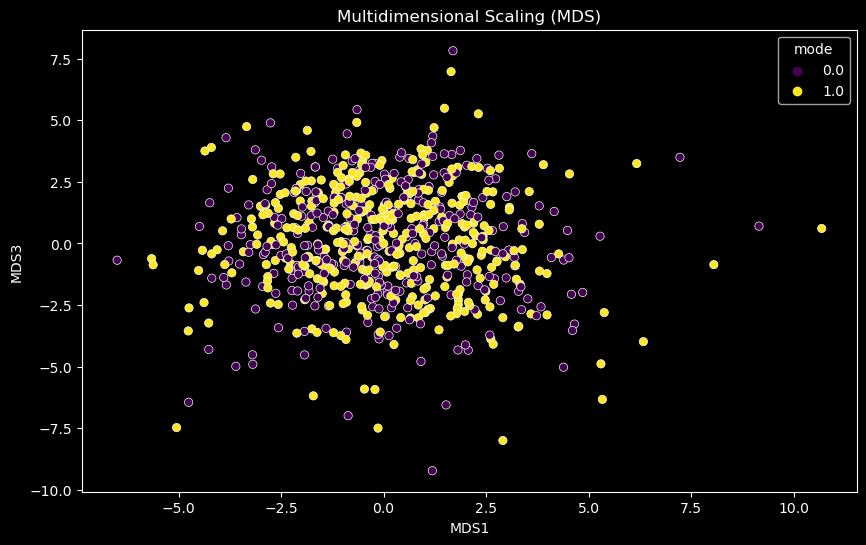

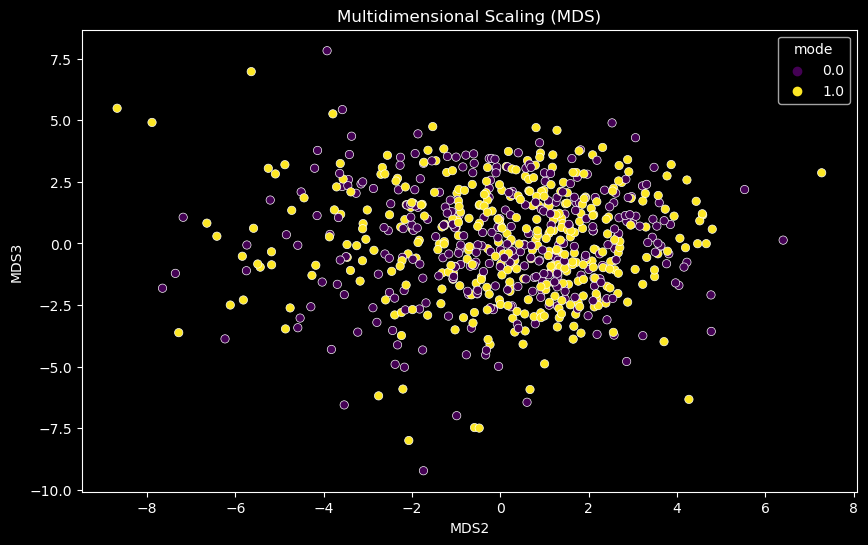

In [118]:
# Plot the scatterplot of the MDS result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS2', hue = 'mode', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS3', hue = 'mode', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS2', y='MDS3', hue = 'mode', data=mds_df, palette='viridis')
plt.xlabel('MDS2')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

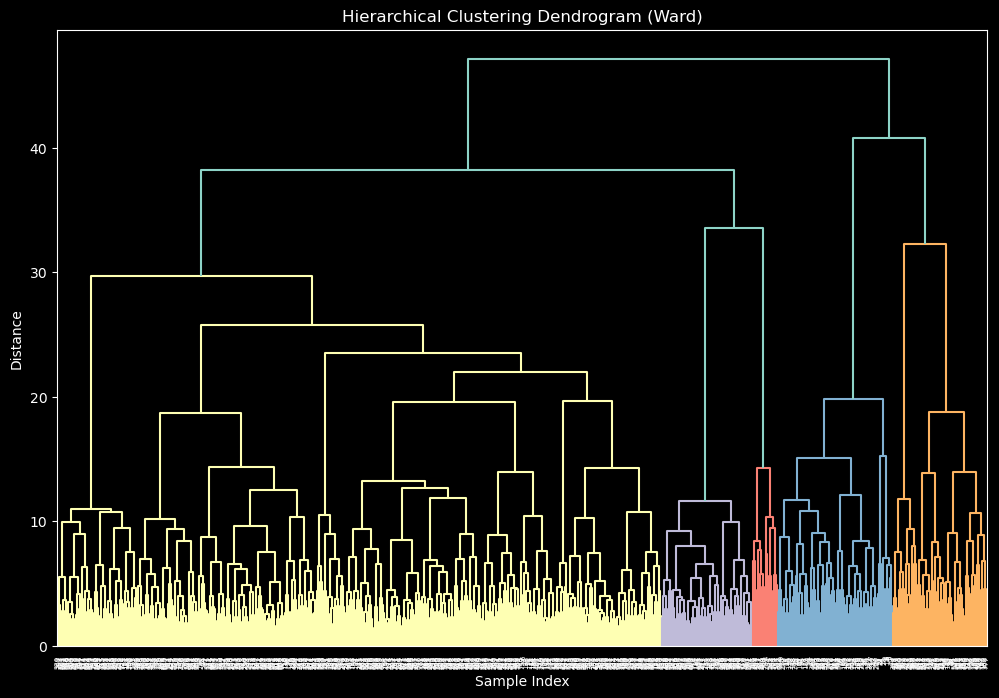

In [131]:
plt.figure(figsize=(12, 8))
dendrogram(linkage(scaled_data, method = 'ward'))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## 5 clusters

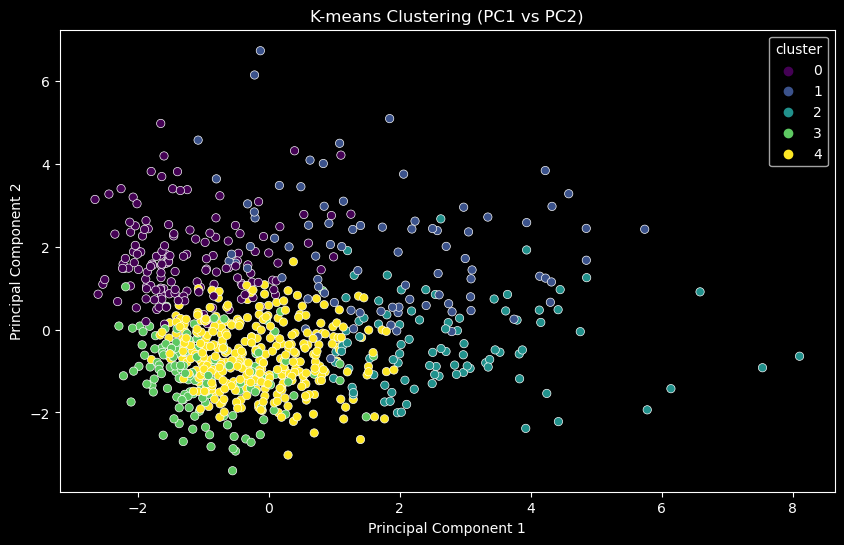

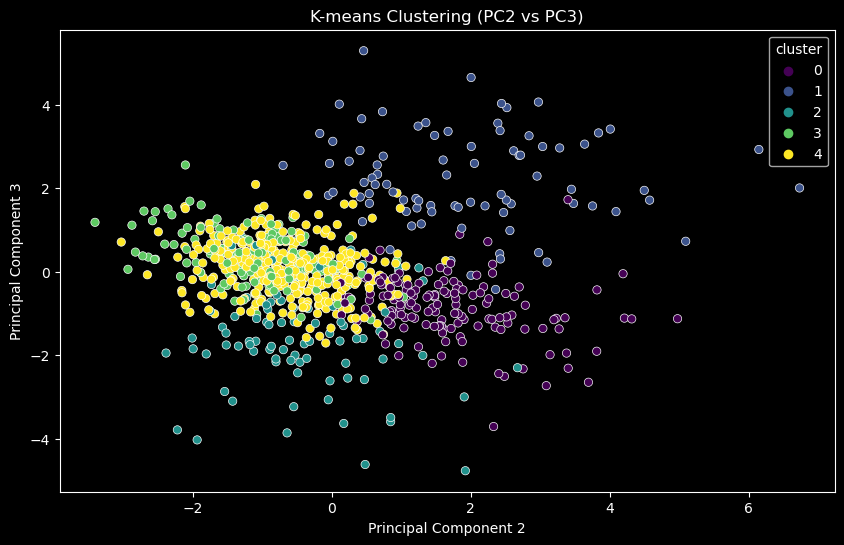

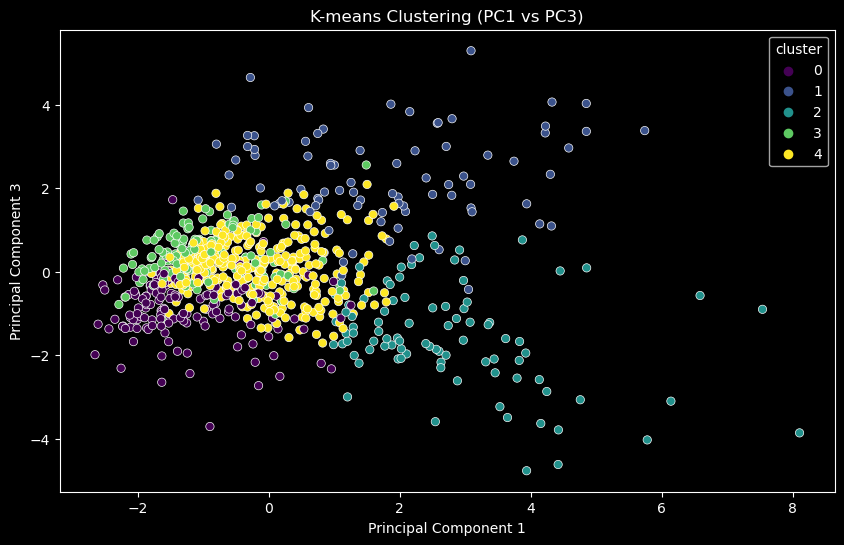

In [120]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the DataFrame
pca_df['cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering (PC2 vs PC3)')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering (PC1 vs PC3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.show()

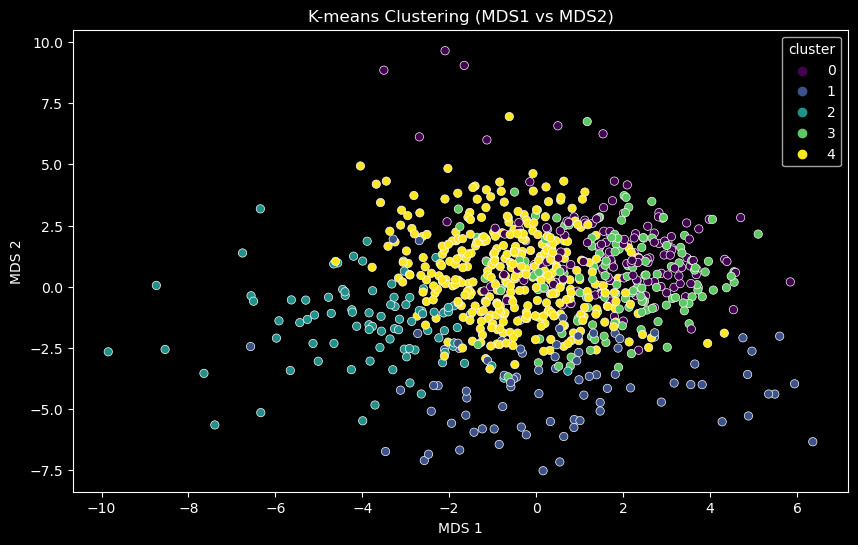

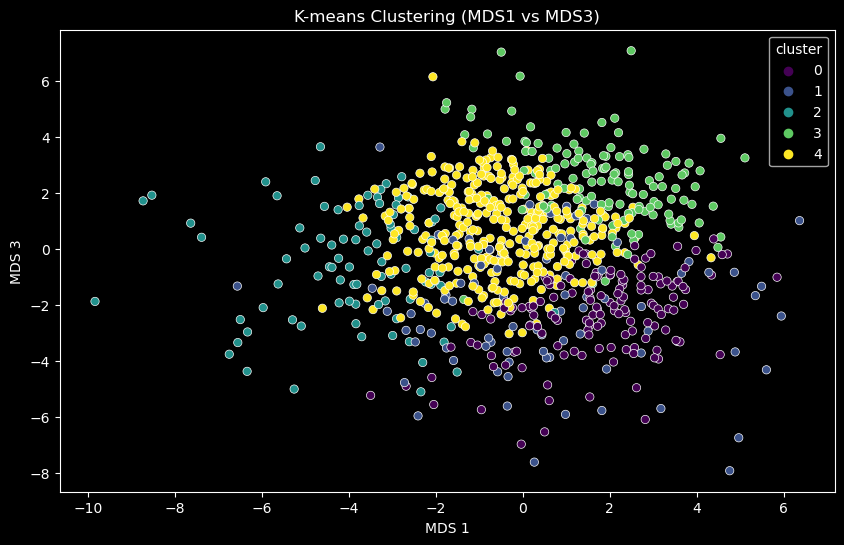

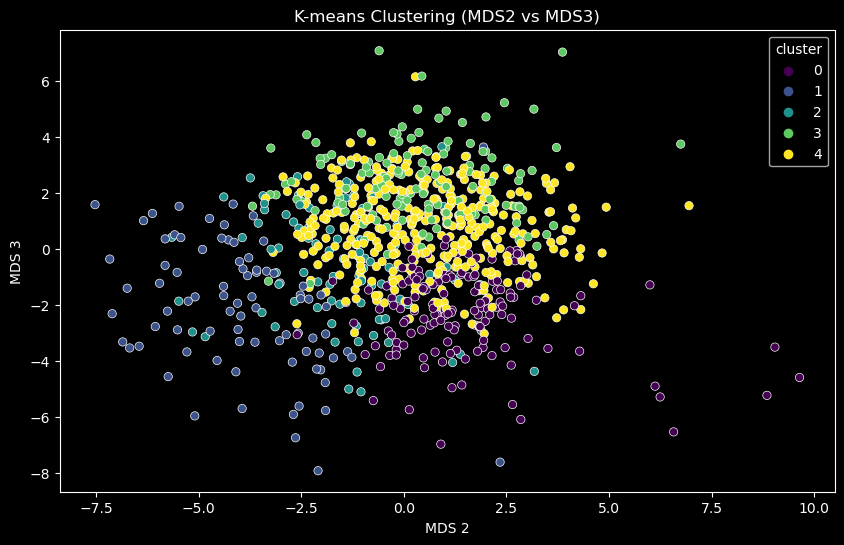

In [132]:
# Add cluster labels to the DataFrame
mds_df['cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS2', hue='cluster', data=mds_df, palette='viridis')
plt.title('K-means Clustering (MDS1 vs MDS2)')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS3', hue='cluster', data=mds_df, palette='viridis')
plt.title('K-means Clustering (MDS1 vs MDS3)')
plt.xlabel('MDS 1')
plt.ylabel('MDS 3')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS2', y='MDS3', hue='cluster', data=mds_df, palette='viridis')
plt.title('K-means Clustering (MDS2 vs MDS3)')
plt.xlabel('MDS 2')
plt.ylabel('MDS 3')
plt.show()